# Assignment — Diffusions and epidemics on networks

In [1]:
import networkx as nx
from tqdm.notebook import trange
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.optimize import minimize
from IPython.display import HTML
from zlib import adler32
import matplotlib.pyplot as plt

### Task 1. Euler method (0 points)

Euler method is a simple numerical procedure for solving ordinary differential equations (ODEs) with a given initial values.  For example, if we want to solve an equation

$$dx/dt = \sin(x)$$

with initial value $x = x_0$, we can subtitute $dx = \Delta x = x_{i+1} - x_{i}$ and $dt = \Delta t$, therefore we obtain

$$\frac{x_{i+1} - x_i}{\Delta t} = \sin(x)$$ 
$$x_{i+1} = x_i + \sin(x)\Delta t$$

Let $\Delta t = 0.1$, and then we can solve the equation using this iterative form as follows

In [2]:
def solve_sinx(x0, dt, k):
    x = x0
    solution = [x0]
    for _ in range(k):
        dx = np.sin(x) * dt
        x = x + dx
        solution.append(x)
    return solution

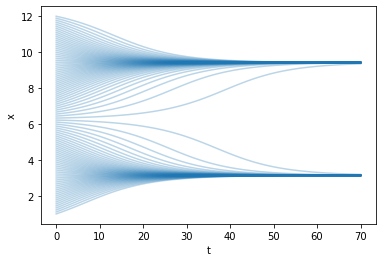

In [3]:
dt = 0.1
for x0 in np.linspace(1, 12, 100):
    solution = solve_sinx(x0, dt, 70)
    plt.plot(solution, c='tab:blue', alpha=0.3);
plt.xlabel('t')
plt.ylabel('x')
plt.show()

Assume that we want to solve the famous chaotic Lorenz System:

$$
\begin{cases}
\frac{dx}{dt} = \sigma(y-x)\\
\frac{dy}{dt} = x(\rho - z) - y\\
\frac{dz}{dt} = xy - \beta z\\
\end{cases}
$$

with parameters $\rho = 28$, $\sigma = 10$, $\beta = 8/3$ and initial values $x = y = z = 10$.

Write a function `lorenz` that takes initial values, parameters, time increment `dt`, number of iterations `k` and returns np.array with solution of the form `[[x0, y0, z0], [x1, y1, z1], ...]` so that number of rows is `k+1`.

In [4]:
def lorenz(x0, y0, z0, rho, sigma, beta, dt, k):
    # YOUR CODE HERE
    x, y, z = x0, y0, z0
    solution = [[x0, y0, z0]]
    for _ in range(k):
        dx = sigma * (y - x) * dt
        dy = (x * (rho - z) - y) * dt
        dz = (x * y - beta * z) * dt
        x = x + dx
        y = y + dy
        z = z + dz
        solution.append([x, y, z])
    return np.array(solution)

In [5]:
sim = lorenz(10., 10., 10., 28., 10., 8/3, 0.01, 8000-1)
assert sim.shape == (8000, 3)
assert np.all(sim[0] == [10, 10, 10])
assert np.all(sim[1].round(2) == [10., 11.7, 10.73])
assert np.all(sim[2].round(2) == [10.17, 13.31, 11.62])
assert adler32(str(sim[3].round(2)[0]).encode()) == 48496892

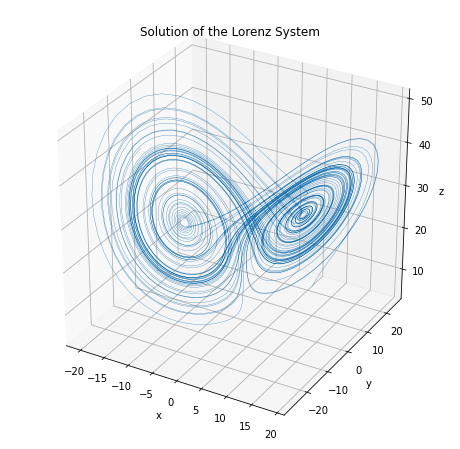

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
xs, ys, zs = sim[:, 0], sim[:, 1], sim[:, 2]
ax.plot(xs, ys, zs, lw=0.3)
plt.title('Solution of the Lorenz System')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### Task 2. SI model (0 points)

Consider a simple model of an epidemic — SI model. S — susceptible, I — infectious. Initialy we only have a few infected persons and all others are susceptible. Then some susceptible people become infected with infection rate $\beta$. The model is defined as follows:

Dynamic form

$$S \underset{\beta SI}{\to} I$$

Equation form

$$\frac{dI}{dt} = \beta \frac{S}{N}I$$

$$S + I = N$$

where $N$ is the total population.

Write a function `si_epidemic` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, time increment `dt`, number of iterations `k` and returns a returns np.array with solution of the form `[[S0, I0], [S1, I1], ...]` so that number of rows is k+1.

In [7]:
def si_epidemic(total, I0, beta, dt, k):
    # YOUR CODE HERE
    I, S = I0, total - I0
    solution = [[S, I]]
    for _ in range(k):
        dI = beta * S / total * I * dt
        I = I + dI
        S = total - I
        solution.append([S, I])
    return np.array(solution)

In [8]:
solution = si_epidemic(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert solution.shape == (130, 2)
assert np.all(solution[0] == [999, 1])
assert np.all(solution[10].round(2) == [995.97, 4.03])
assert np.all(solution[-1].round(2) == [0, 1000])
assert adler32(str(solution[100].round(2)[0]).encode()) == 32047304

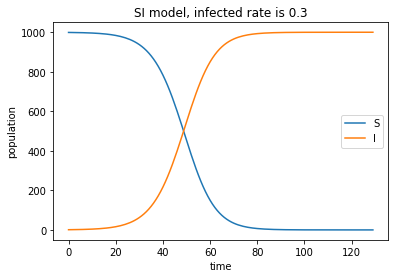

In [9]:
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

Let us look at the plot of epidemic dynamics with the same setup but $\beta = 0.1$.

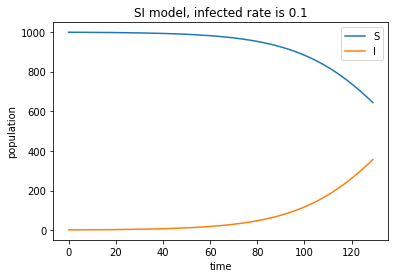

In [10]:
solution = si_epidemic(total=1000, I0=1, beta=0.1, dt=0.5, k=130-1)
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.1')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 3. SIR model (2 points)

The next model is SIR. S — susceptible, I — infectious, R — recovered people. Initialy we only have a few infected persons and others are susceptible. Then some susceptible people become infected with infection rate $\beta$ and some infected people recover with recovery rate $\gamma$. There is no chance to infect after recovering. The model is defined as follows:

Dynamic form

$$S \underset{\beta SI}{\to} I \underset{\gamma I}{\to} R$$

Equation form (in proportions of the population)

$$\begin{cases}
ds/dt = -\beta si\\
di/dt = \beta si - \gamma i\\
dr/dt = \gamma i\\
s+i+r = 1
\end{cases}$$

Write a function `sir_epidemic` that takes an initial proportion `s0`, `i0`, `r0`, infection rate `beta`, recovery rate `gamma`, a number of steps `k` and time increment `dt`. The function returns np.array of shape `(k+1, 3)` with `s`, `i`, `r` proportion in each step. The first row contains an initial proportion.

In [11]:
def sir_epidemic(s0, i0, r0, beta, gamma, k, dt):
    # YOUR CODE HERE
    solution = [[s0, i0, r0]]
    s, i, r = s0, i0, r0
    for _ in range(k):
        ds = - beta * s * i * dt
        dr = gamma * i * dt
        s = s + ds
        r = r + dr
        i = 1 - s - r
        solution.append([s, i, r])
    return np.array(solution)

In [12]:
s0, i0, r0 = 0.99, 0.01, 0
beta, gamma = 0.6, 0.1
dt = 1
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
assert epidemic.shape == (81, 3)
assert np.all(epidemic[0] == [0.99, 0.01, 0.  ])
assert np.all(epidemic[5].round(2) == [0.92, 0.07, 0.01])
assert np.all(epidemic[80].round(2) == [0, 0, 1])
assert adler32(str(epidemic[10].round(2)[1]).encode()) == 32112840

Here is also the critical point for a basic reproduction number $R_0 = \beta / \gamma$

* If $R_0 > 1$: Endemic State,  $r(+\infty) \to 1$
* If $R_0 < 1$: Disease-free State, $r(+\infty) \to \text{const}$

where $r(t)$ is the share of recovered people at the time moment $t$.

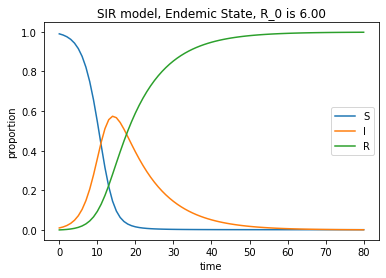

In [13]:
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Endemic State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

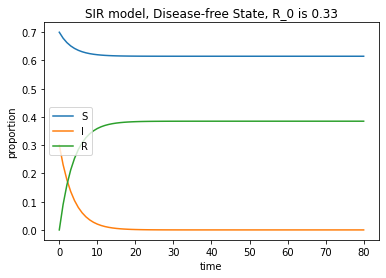

In [14]:
s0, i0, r0 = 0.7, 0.3, 0.
dt = 1
beta, gamma = 0.1, 0.3
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Disease-free State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

### Task 4. Diffusions on networks (2 points)

A diffusion process is a propagation model, where node values $\phi$ (say, 'heat') spread out of high concentration zone. Consider the diffusion on grid of the size 20x20. Let there be a 3x3 sub-grid with a heat value 3 and a 7x5 sub-grid with a heat value 1. All other nodes has a value 0. The initial heat values is $\phi_0$.

In [15]:
phi_map = np.zeros((20, 20))
phi_map[1:4, 1:4] = 3
phi_map[10:15, 8:15] = 1
phi0 = phi_map.flatten()

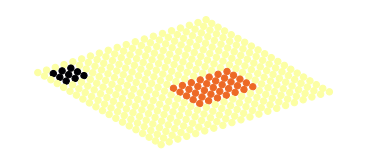

In [16]:
plt.figure(figsize=(7*0.7, 3*0.7))
gridG = nx.grid_graph((20, 20))
nx.draw_kamada_kawai(
    gridG,
    cmap=plt.cm.inferno_r,
    vmin=0, vmax=3,
    width=0,
    node_size=40,
    node_color=phi0)

Create a diffusion simulation based on this diffusion equation

$$\frac{d\phi}{dt} = -CL\phi$$

where $L$ is a graph Laplacian.

Write a function `next_phi` that takes an adjacency matrix `A`, np.array with previous heat values `phi`, constant `C` and time increment `dt`. The function returns a np.array with the next heat values.

In [17]:
def next_phi(A, phi, C, dt):
    # YOUR CODE HERE
    L = np.diag(A.sum(axis=0)) - A
    dphi = - C * L @ phi * dt
    return phi + dphi

In [18]:
A = nx.to_numpy_array(gridG)
C = 0.1
dt = 2
phi = next_phi(A, phi0, C, dt)
assert phi.shape == (400,)
assert phi.sum() == phi0.sum()
assert phi.std() < phi0.sum()
assert round(phi[20:25].sum(), 4) == 7.2

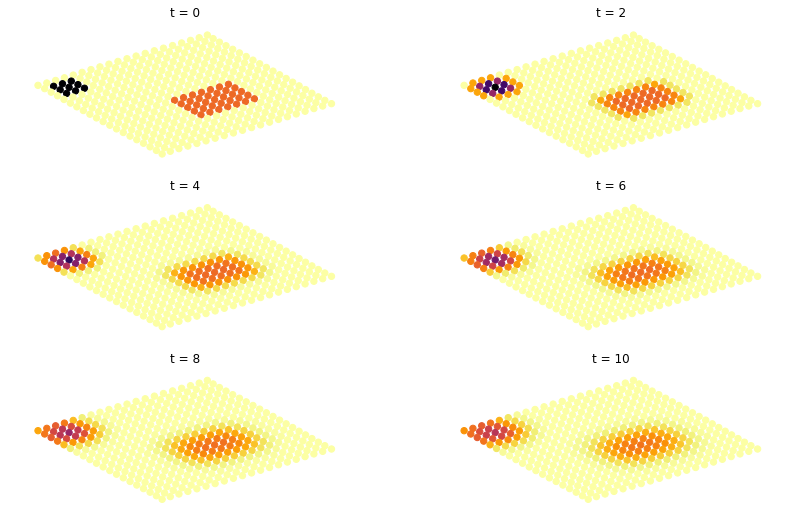

In [19]:
plt.figure(figsize=(7*2, 3*3))

phi = phi0
for i in range(6):
    plt.subplot(3, 2, i+1)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi)
    plt.title('t = {}'.format(i*dt))
    phi = next_phi(A, phi, C, dt)
phi12 = phi

We can run simulation step-by-step as long as we need, but fortunately, there is an analytical solution

$$\phi(t) = \sum_k a_k(t) v_k = \sum_k a_k(0) e^{-C\lambda_k t} v_k$$

where $a_k(t) = \phi(t)^T v_k$ and $v_k$ is k-th smallest eigenvector of a Laplacian.

Write a function `phi_t` that takes an adjacency matrix `A`, np.array with initial heat values `phi0`, constant `C` and time moment `t`. The function returns a np.array with the heat values at time moment `t`. Use `np.linalg.eigh` or `scipy.linalg.eigh` for a symmetric matrix.

In [20]:
def phi_t(A, phi0, C, t):
    # YOUR CODE HERE
    phi = np.zeros(phi0.shape[0])

    L = np.diag(A.sum(axis=0)) - A
    lambd, v = np.linalg.eigh(L)

    for k in range(len(v)):
        phi += phi0.T @ v[:, k] * np.exp(-C * lambd[k] * t) * v[:, k]

    return phi

In [21]:
assert phi_t(A, phi0, C, 0).shape == (400,)
assert round(np.linalg.norm(phi0 - phi_t(A, phi0, C, 0)), 4) == 0
assert round(np.linalg.norm(phi12 - phi_t(A, phi0, C, 12)), 4) < 0.4
assert len(np.unique(phi_t(A, phi0, C, 10000).round(4))) == 1
assert phi_t(A, phi0, C, 10000).round(4)[0] == phi0.sum() / len(phi0)

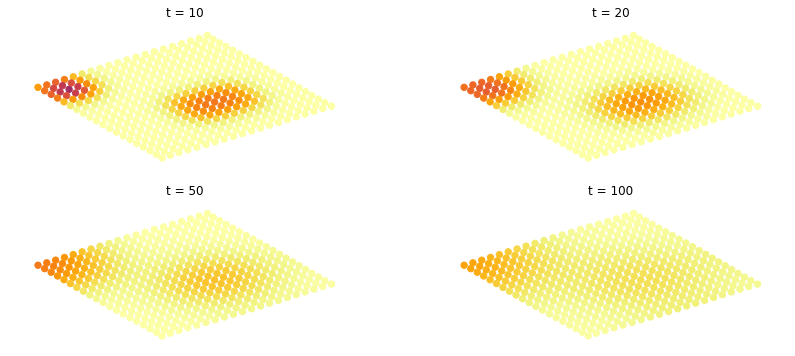

In [22]:
plt.figure(figsize=(7*2, 3*2))
i = 1
for t in [10, 20, 50, 100]:
    plt.subplot(2, 2, i)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi_t(A, phi0, C, t))
    plt.title('t = {}'.format(t))
    i += 1

### Task 5. SIS model on networks (0 points)

Let us consider epidemic models on networks. SIS model is described by a dynamic form

$$S \to_{\beta SI} I \to_{\gamma I} S$$

To model epidemics on networks, we need to use probabilistic approach. First, let us define a function that gives us a random sample of available nodes by given probability.

Here is a function `select_nodes` that takes a np.array `vec`, where an i-th element is a number of neighbors that can affect to i-th node with probability `proba`. For example, `vec` can represent the number of infected neighbors, say [0, 2, 1] and then the probability is an infected rate $\beta$. That means the first node has no infected neighbors, the second has two infected neighbors, the third has one infected neighbor. Thereby, the second node has a $(1 - (1-\beta)^2)$ probability of getting infected.

In [23]:
def select_nodes(vec, proba):
    sample = np.random.rand(len(vec))
    res = sample < (1 - (1 - proba)**vec)
    return res.astype('int')

Let us infect a few random nodes and simulate a propogation of an epidemic.

Write a function `sis_networks` that takes a graph `G`, np.array with an initial indicator vector `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I`). Any node must be susceptible or infected at any step. Also the function takes rates `beta`, `gamma`, number of steps `k`. The function returns a np.array of shape `(k+1, 2, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column and `I` in the second.

_Hint: to calculate the number of infected neighbors, use `I @ A * S`_

In [24]:
def sis_networks(G, S, I, beta, gamma, k):
    # YOUR CODE HERE
    A = nx.to_numpy_array(G)
    solution = [[S.copy(), I.copy()]]
    for _ in range(k):
        dI = select_nodes(I @ A * S, beta)
        dS = select_nodes(I, gamma)
        I = I + dI - dS
        S = 1 - I
        solution.append([S.copy(), I.copy()])
    return np.array(solution)

In [25]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.2

epidemic = sis_networks(G, S, I, beta, gamma, 100)
assert epidemic.sum() == 5050
assert epidemic.shape == (101, 2, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050
sigma = 6.3853
mean = 16.0198
assert mean - 2*sigma < round(epidemic.sum(axis=2)[:, 0].mean(), 4) < mean + 2*sigma
sigma = 5.953
mean = 34.2178
assert mean - 2*sigma < round(epidemic.sum(axis=2)[:, 1].mean(), 4) < mean + 2*sigma

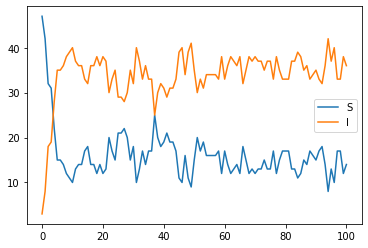

In [26]:
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I']);

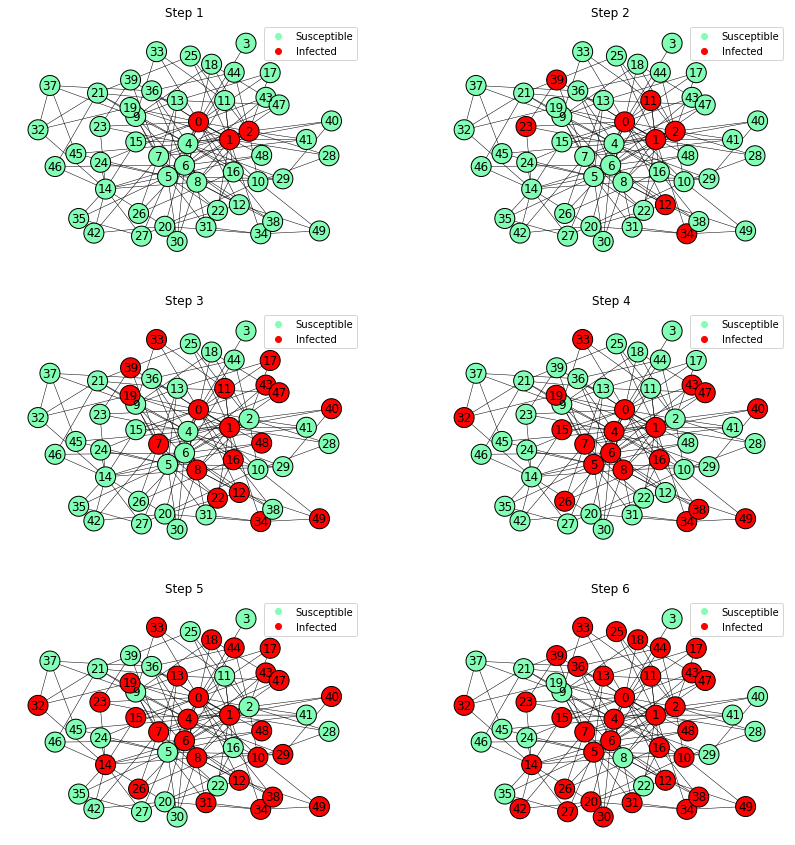

In [27]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=I+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

### Task 6. SIRS model on networks (2 points)

Let us implement SIRS node-level model
$$S \to_{\beta SI} I \to_{\gamma I} R \to_{\delta R} S$$

Write a function `sirs_networks` that takes a graph `G`, np.array with initial indicator `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I` and `R`). Also the function takes rates `beta`, `gamma`, `delta`, number of steps `k`. The function returns a np.array of shape `(k+1, 3, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column, `I` in the second, `R` in the third.

In [28]:
def sirs_networks(G, S, I, R, beta, gamma, delta, k):
    # YOUR CODE HERE
    A = nx.to_numpy_array(G)
    solution = [[S.copy(), I.copy(), R.copy()]]
    for _ in range(k):
        dI = select_nodes(I @ A * S, beta)
        dR = select_nodes(I, gamma)
        dS = select_nodes(R, delta)
        I = I + dI - dR
        S = S + dS - dI
        R = 1 - I - S
        solution.append([S.copy(), I.copy(), R.copy()])
    return np.array(solution)

In [29]:
G = nx.barabasi_albert_graph(40, 3, seed=0)
I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
R = np.zeros(len(G))

beta = 0.1
gamma = 0.3
delta = 0.1

epidemic = sirs_networks(G, S, I, R, beta, gamma, delta, 200)
assert epidemic.shape == (201, 3, 40)
assert (epidemic.sum(axis=1) == 1).sum() == 8040
assert (epidemic[200].sum(axis=1) == [40, 0, 0]).sum() == 3

for k in range(6):
    for node in G.nodes:
        if epidemic[k, 0, node] > epidemic[k+1, 0, node]:
            assert epidemic[k+1, 1, node] == 1
            neighbors = np.array([n for n in G.neighbors(node)])
            assert epidemic[k, 1][neighbors].sum()
        elif epidemic[k, 1, node] > epidemic[k+1, 1, node]:
            assert epidemic[k+1, 2, node] == 1
        elif epidemic[k, 2, node] > epidemic[k+1, 2, node]:
            assert epidemic[k+1, 0, node] == 1

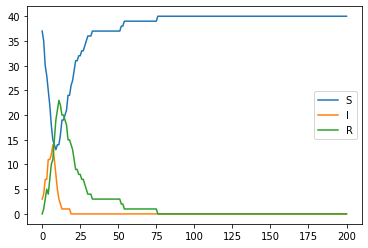

In [30]:
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I', 'R']);

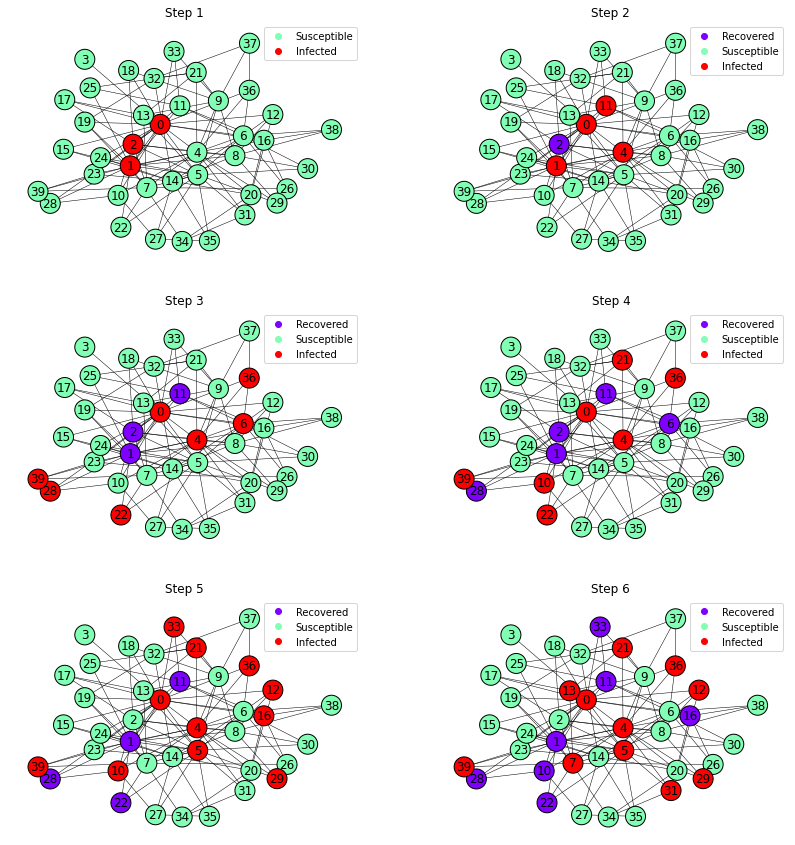

In [31]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I, R in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=(S + I*2), 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    if len(nodes.legend_elements()[0]) == 2:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Susceptible', 'Infected'])
    else:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Recovered', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

We can also can model "the second waves" using delta parameter

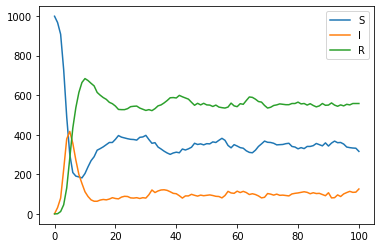

In [32]:
G = nx.barabasi_albert_graph(1000, 3, seed=0)

I = np.zeros(len(G))
I[0] = 1
S = 1 - I
R = np.zeros(len(G))

epidemic = sirs_networks(G, S, I, R, 0.3, 0.4, 0.07, 100)
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I', 'R']);

### Erdos-Renyi graph

This part of the assignment is devoted to models of influence propagation: the linear threshold model and independent cascade model. There are many applications of these types of models, for example:
* Rise of a political movement in an unstable society
* “Word-of-mouth” effects: when we have access to plentiful information, such as when we evaluate new technologies, risky financial assets, or job candidates, we often lack the ability to make sense of it; hence, we rely on the advice of trusted friends, colleagues, or advisors
* “Viral marketing” effects in the success of new products
* Adoption of medical and agricultural innovations
* Cascading failures in power systems
* Desicion making by majority voting

Let us consider these models on directed Erdos Renyi graph.

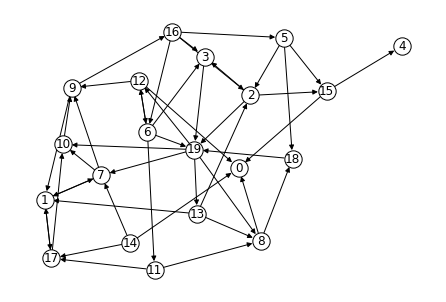

In [33]:
n = 20
G = nx.erdos_renyi_graph(n, 0.11, 0, True)

plt.figure(figsize=(6, 4))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color='white', edgecolors='black')

### Task 7. Linear threshold model (0 points)

Linear threshold model is defined as follows. Given a choice of all nodes’ thresholds, and an initial set of active nodes, the diffusion process unfolds deterministically in discrete steps: in step $t$, all nodes that were
active in step $t-1$ remain active; furthermore, each currently inactive node becomes active if and only
if the total share of its active neighbors is at least node's threshold.

Write a function `linear_threshold` that takes a graph, np.array `active_nodes` with zeros and ones (if `active_nodes[i]` is 1 then the i-th node is active), np.array of `thresholds`. The function propagates influence and stops when the model stops changing. The function returns a np.array with active nodes in each step. The first step is initial activation, the last and the second to last steps are the same (we want to see that the propogation stops changing).

In [34]:
def linear_threshold(G, active_nodes, thresholds):
    # YOUR CODE HERE
    simulation = [active_nodes]
    while True:
        new_active = active_nodes.copy()
        for node in np.argwhere(active_nodes == 0):
            node = node[0]
            predecessors = np.array([i for i in G.predecessors(node)])
            if not predecessors.shape[0]:
                continue
            if active_nodes[predecessors].sum() / predecessors.shape[0] >= thresholds[node]:
                new_active[node] = 1
        active_nodes = new_active.copy()
        simulation.append(active_nodes)
        if np.all(simulation[-1] == simulation[-2]):
            break
    return np.array(simulation)

In [35]:
np.random.seed(5)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.5, 1, n)

sim = linear_threshold(G, active_nodes, thresholds)

assert sim.shape == (4, 20)
assert np.all(sim[0] == active_nodes)
assert np.all(sim[-1] == sim[-2])
assert sim[0, 4] == 0
assert sim[2, 4] == 1
assert sim[0, 3] == 0
assert sim[1, 15] == 1

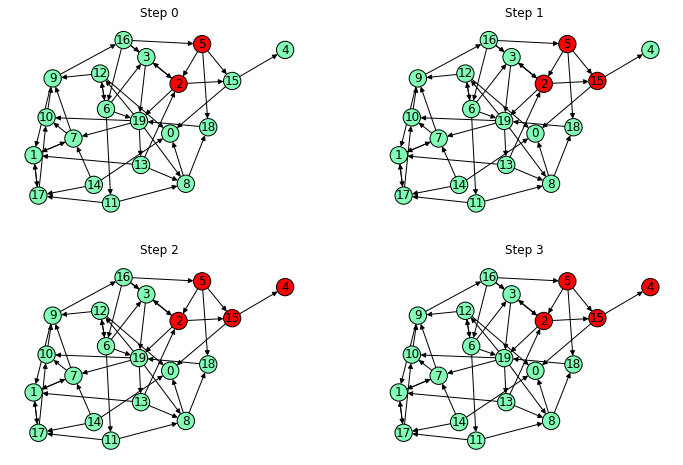

In [36]:
plt.figure(figsize=(6*2, 4*2))

for i, color in enumerate(sim):
    plt.subplot(2, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

### Task 8. Independent cascade model (2 points)

The next type is Independent cascade model. We again start with an initial set of active nodes, and the process unfolds in discrete steps according to the following randomized rule. When node $v$ first becomes active in step $t$, it is given a single chance to activate each currently inactive neighbor $w$; it succeeds with a probability $p_{v,w}$ — a parameter of the system — independently of the history thus far. (If $w$ has multiple newly activated neighbors, their attempts are sequenced in an arbitrary order.) If $v$ succeeds, then $w$ will become active in step $t+1$; but whether or not $v$ succeeds, it cannot make any further attempts to activate $w$ in subsequent steps.

Write a function `independent_cascade` that takes a graph, np.array active_nodes with zeros and ones (if active_nodes[i] is 1 then the i-th node is active), np.array with propagation probabilities `prop_proba` for edges ordered by `G.edges`. The function propagates influence and stops when the model stops changing. The function returns a np.array with active nodes in each step. The first step is initial activation, the last and the second to last steps are the same (we want to see that the model stops changing).

In [37]:
def independent_cascade(G, active_nodes, prop_proba):
    # YOUR CODE HERE
    simulation = [active_nodes]
    edges_prob = dict(zip(G.edges, prop_proba.copy()))
    while True:
        new_active = active_nodes.copy()
        for u, v in G.edges:
            if new_active[u] and not new_active[v] and edges_prob[(u, v)] != 0:
                if np.random.rand() <= edges_prob[(u, v)]:
                    new_active[v] = 1
                edges_prob[(u, v)] = 0
        active_nodes = new_active.copy()
        simulation.append(active_nodes)
        if np.all(simulation[-1] == simulation[-2]):
            break
    return np.array(simulation)

In [38]:
np.random.seed(1)
active_nodes = np.zeros(20, 'int')
active_nodes[np.random.choice(np.arange(20), 2, False)] = 1
prop_proba = np.random.rand(len(G.edges))

sims = []
n_steps = []
for i in range(1000):
    sim = independent_cascade(G, active_nodes, prop_proba)
    sims.append(sim)
    n_steps.append(len(sim))
sigma = 1.9165
mean = 5.103
assert mean - 2*sigma < np.mean(n_steps) < mean + 2*sigma
sim = sims[n_steps.index(6)]
assert sim.shape == (6, 20)
assert np.all(sim[0] == active_nodes)
assert np.all(sim[-1] == sim[-2])
for i in range(1, 4):
    attempts = sim[i] - sim[i-1]
    new_active = sim[i+1] - sim[i]
    has_edge = False
    for j in np.argwhere(attempts == 1):
        for k in np.argwhere(new_active == 1):
            if G.has_edge(j[0], k[0]):
                has_edge = True
    assert has_edge

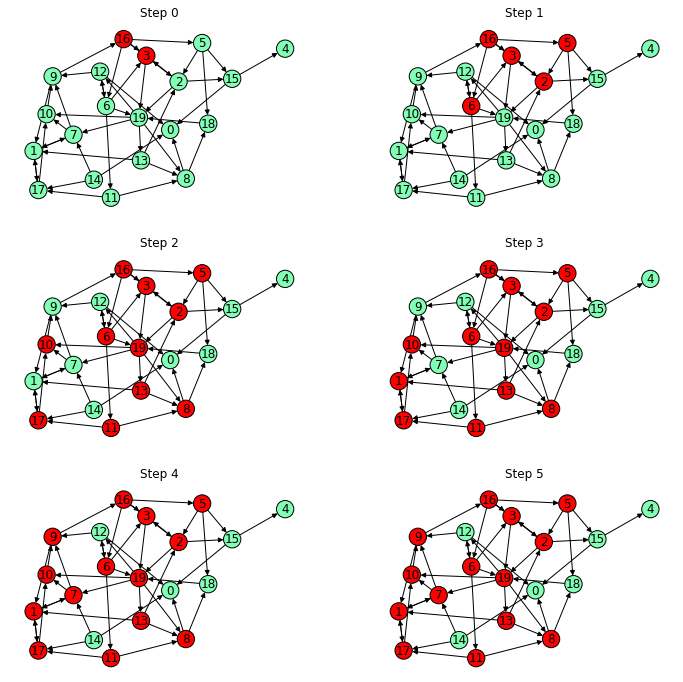

In [39]:
plt.figure(figsize=(6*2, 4*3))

for i, color in enumerate(sim):
    plt.subplot(3, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

### Task 9. Greedy influence maximization (2 points)

The influence is the expected number of active nodes at the end of the process

$$\sigma(A_0) = \mathbb E[|A_t|]$$

where $A_0$ is an initial active nodes and $A_t$ is an active nodes at the end. Linear threshold model is deterministic and then $E[|A_t|] = |A_t|$.

The influence maximization problem asks, for a given number of initial active nodes $k$, to find a set of nodes that gives maximum influence. It is NP-hard problem, but a useful property is that it can be solved in polynomial time by greedy optimization with guaranteed performance slightly better than 63%. Proofs are [here](https://theoryofcomputing.org/articles/v011a004/v011a004.pdf). The algorithm is:

1. Let $A_0 = \emptyset$
2. For every node $i$, calculate the influence $\sigma(A_0 \cup \{i\})$
3. Put the node with the largest influence into the initial active set $A_0 = A_0 \cup \{i\}$
4. Repeat 2-3 until $|A_0| = k$

Write a function `greedy_influence_max` that takes a graph, `thresholds` of linear threshold model, number of active nodes `k` and calculates initial active nodes by greedy algorithm. The function returns a np.array with zeros and ones (if `active_nodes[i]` is 1 then the i-th node is active).

In [40]:
def greedy_influence_max(G, thresholds, k):
    # YOUR CODE HERE
    active_nodes = np.zeros_like(G.nodes)
    while np.sum(active_nodes) < k:
        best_node, max_influence = None, 0
        for node in G.nodes():
            if active_nodes[node]:
                continue
            new_active = active_nodes.copy()
            new_active[node] = 1
            influence = np.mean(linear_threshold(G, new_active, thresholds)[-1])
            if influence > max_influence:
                max_influence, best_node = influence, node
        active_nodes[best_node] = 1
    return active_nodes

In [41]:
n = 100
G = nx.erdos_renyi_graph(n, 0.07, 0, True)

np.random.seed(0)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.1, 0.8, n)

best_active = greedy_influence_max(G, thresholds, 2)
assert best_active.shape == (100,)
assert best_active.sum() == 2
sim = linear_threshold(G, best_active, thresholds)
assert sim[-1].sum() > 21 * 0.63

Here is the same model as in the linear threshold task, but with a better initial active set.

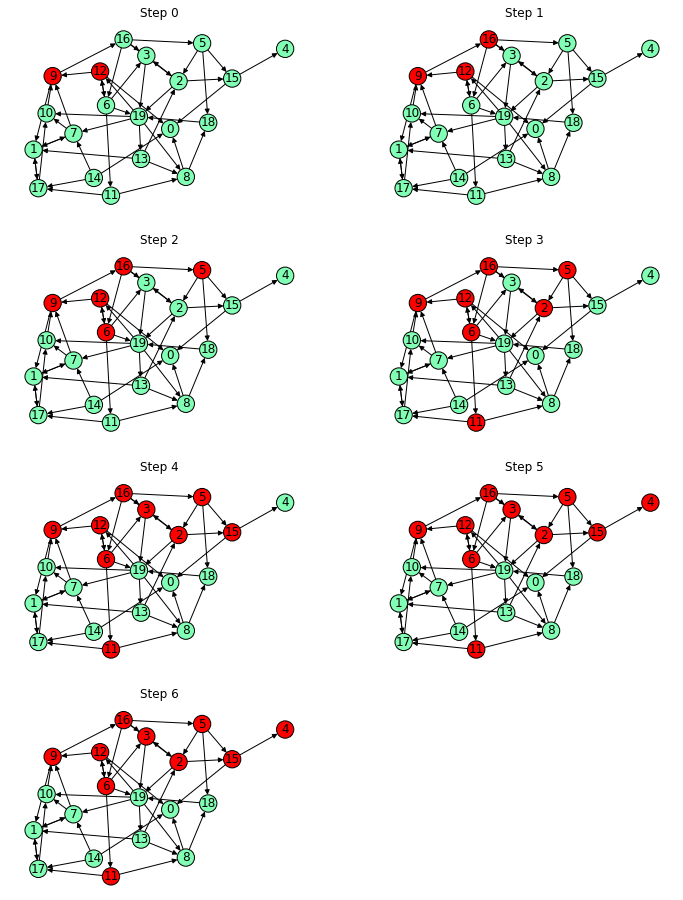

In [42]:
n = 20
G = nx.erdos_renyi_graph(n, 0.11, 0, True)

np.random.seed(5)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.5, 1, n)

best_active = greedy_influence_max(G, thresholds, 2)
sim = linear_threshold(G, best_active, thresholds)

plt.figure(figsize=(6*2, 4*4))

for i, color in enumerate(sim):
    plt.subplot(4, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()